## Setup

In [1]:
import sys

sys.path.insert(0, 'backend_functions')

import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT
from ROOT import TH1F, TH2F, TDirectory, TH1D

import top 
from top import *

importlib.reload(sf)
from selection_functions import *


Welcome to JupyROOT 6.18/00


In [2]:
import NuMIGeoWeights
importlib.reload(NuMIGeoWeights)

# the default option is FHC, RHC needs different arguments - need to create still 
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights() 

In [3]:
ISRHC = False

In [4]:
# POT normalization factors

if not ISRHC: 
    run2_overlay_pot = 1.86811E20    # set 6 = 3.92631E19  
    print('for set 5 ONLY!')

    run1_overlay_pot = 7.59732E20 # cv det var sample (less stats)
    
pot_scale = run2_overlay_pot / run1_overlay_pot


for set 5 ONLY!


In [5]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

RUN2_OVRLY = ""
RUN1_OVRLY = ""

if not ISRHC: 

    RUN2_OVRLY = "/uboone/data/users/kmiller/Run2NtupleMaker/prodgenie_numi_standard_CV_run2_FHC/"
    run2_overlay = uproot.open(RUN2_OVRLY+"neutrinoselection_filt_run2_fhc_overlay_set5.root")[fold][tree]

    # using detvar because less statistics (for now)
    RUN1_OVRLY = "/uboone/data/users/kmiller/uBNuMI_CCNp/ntuples/run1/systematics/detvar/standard_overlay/" 
    run1_overlay = uproot.open(RUN1_OVRLY+"neutrinoselection_filt_run1_overlay_CV.root")[fold][tree]

uproot_v = [run2_overlay, run1_overlay]


In [6]:
variables = [
    "trk_score_v", 
    "shr_tkfit_dedx_Y", 
    "n_tracks_contained", 
    "NeutrinoEnergy2",
    "run","sub","evt",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "shrsubclusters0","shrsubclusters1","shrsubclusters2",
    "trkshrhitdist2",
    "n_showers_contained", 
    "shr_phi", "trk_phi", "trk_theta",
    "shr_score", 
    "trk_energy", 
    "tksh_distance", "tksh_angle",
    "shr_energy_tot_cali", "shr_energy_cali", 
    "nslice", 
    "contained_fraction",
    "shrmoliereavg", "shr_px", "shr_py", "shr_pz", "flash_pe", "flash_time"
]

# MC only variables
mc_var = ["nu_pdg", "shr_theta", "true_e_visible", "ccnc", 
          "nproton", "nu_purity_from_pfp", "nu_e", "npi0", "npion",
          "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
          "weightTune", "weightSpline", "weightSplineTimesTune", 
          "true_nu_px", "true_nu_py", "true_nu_pz", 
          "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
          "swtrig_pre", "ppfx_cv", "mc_pdg", "topological_score"]#, "opening_angle"]

sys_genie = ["weightsGenie", "weightsReint", 
             "knobRPAup", "knobRPAdn", 
             "knobCCMECup", "knobCCMECdn", 
             "knobAxFFCCQEup", "knobAxFFCCQEdn", 
             "knobVecFFCCQEup", "knobVecFFCCQEdn", 
             "knobDecayAngMECup", "knobDecayAngMECdn", 
             "knobThetaDelta2Npiup", "knobThetaDelta2Npidn", 
             "knobThetaDelta2NRadup", "knobThetaDelta2NRaddn", 
             #"knobRPA_CCQE_Reducedup", "knobRPA_CCQE_Reduceddn", 
             "knobNormCCCOHup", "knobNormCCCOHdn", 
             "knobNormNCCOHup", "knobNormNCCOHdn",    
             "knobxsr_scc_Fv3up", "knobxsr_scc_Fv3dn", 
             "knobxsr_scc_Fa3up", "knobxsr_scc_Fa3dn"]

sys_flux = ['weightsPPFX']

In [7]:
pot_scale

0.24589065617875777

## Create pandas dataframes

In [8]:
# OVERLAY 
run2_overlay = run2_overlay.pandas.df(variables + mc_var + sys_genie + sys_flux, flatten=False)

In [9]:
run1_overlay = run1_overlay.pandas.df(variables + mc_var + sys_genie + sys_flux, flatten=False)

In [10]:
# trk PID

df_v = [run2_overlay, run1_overlay]
    
for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000


In [11]:
for i,df in enumerate(df_v):
    
    # is signal bool 
    df['is_signal'] = np.where((df.swtrig_pre == 1) 
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                             & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    # Add truth level theta & phi angles (detector & beam coordinates)
    df = addAngles(df)
    
    
    df['weightsPPFX'] = df['weightsPPFX']/1000
    df['weightsReint'] = df['weightsReint']/1000
    df['weightsGenie'] = df['weightsGenie']/1000
    
    
    # add beamline geometry weights
    df['weightsNuMIGeo'] = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['thbeam']) , axis=1)
    
    
    # add genie unisim weights 
    if i==1: 
        universes = []
        for evt in df[sys_genie[2:-4]].values: 
            if np.all(evt == 1): 
                universes.append( [0 for j in range(len(sys_genie[2:]))] )
                
            else: 
                universes.append( list(evt) + [0, 0, 0, 0] ) # dirt doesn't have variations for the last 4 knobs 
        
    else: 
        universes = []
        for evt in df[sys_genie[2:]].values: 
            if np.all(evt == 1): 
                universes.append( [0 for j in range(len(sys_genie[2:]))] )  # don't include CV neutrinos 

            else: 
                universes.append( evt )

        
    df['weightsGenieUnisim'] = universes
    
    # for easier handling 
    df['weightsGenieUnisim'] = df['weightsGenieUnisim'].apply(lambda x: np.array(x))
    
    # convert things to degrees 
    df['shr_theta_deg'] = df['shr_theta']*(180/np.pi)
    df['shr_phi_deg'] = df['shr_phi']*(180/np.pi)
    df['trk_theta_deg'] = df['trk_theta']*(180/np.pi)
    df['trk_phi_deg'] = df['trk_phi']*(180/np.pi)

## Weights

In [12]:
# clean bad weights & values 

for i,df in enumerate([run2_overlay, run1_overlay]):
     
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.  

        

In [13]:
# total weights - normalize to Run 2 overlay

run2_overlay['totweight_overlay'] = run2_overlay['ppfx_cv']*run2_overlay['weightSplineTimesTune']
run1_overlay['totweight_overlay'] = run1_overlay['ppfx_cv']*run1_overlay['weightSplineTimesTune']*pot_scale


## Are the weights all there? 

In [14]:
title = ""
pot_string = "$3.93 \\times 10^{19}$ POT"

if not ISRHC: 
    title = 'Run 2 FHC (set 6)'

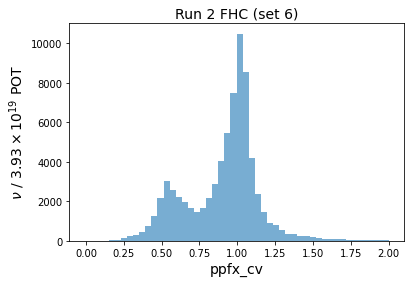

In [15]:
plt.hist(run2_overlay['ppfx_cv'], 50, range=[-0.01, 2], alpha=0.6)

plt.xlabel('ppfx_cv', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title(title, fontsize=14)

plt.show()

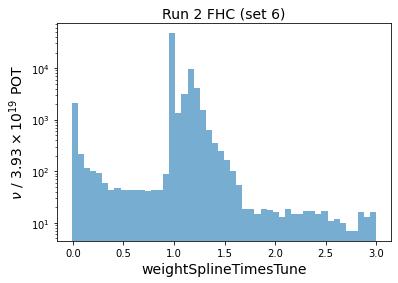

In [16]:
plt.hist(run2_overlay['weightSplineTimesTune'], 50, range=[-0.01, 3], alpha=0.6)

plt.xlabel('weightSplineTimesTune', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title(title, fontsize=14)

plt.yscale('log')

plt.show()

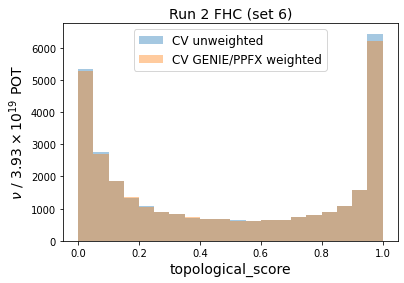

In [22]:
plt.hist(run2_overlay['topological_score'], 20, range=[0, 1], alpha=0.4, label='CV unweighted')
plt.hist(run2_overlay['topological_score'], 20, range=[0, 1], alpha=0.4, weights=run2_overlay.totweight_overlay, 
         label='CV GENIE/PPFX weighted')

plt.xlabel('topological_score', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title(title, fontsize=14)

#plt.yscale('log')

plt.legend(loc='best', fontsize=12)
plt.show()

In [ ]:
# are the systematic weights there? 

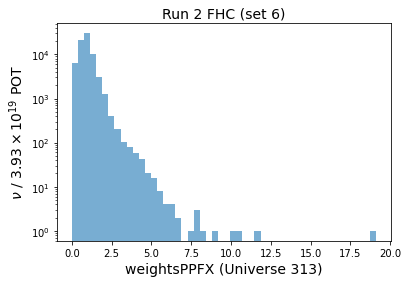

In [23]:
plt.hist(run2_overlay['weightsPPFX'].str.get(313), 50, alpha=0.6)

plt.xlabel('weightsPPFX (Universe 313)', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title(title, fontsize=14)

plt.yscale('log')

plt.show()

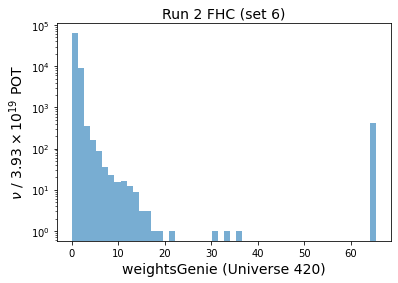

In [24]:
plt.hist(run2_overlay['weightsGenie'].str.get(420), 50, alpha=0.6)

plt.xlabel('weightsGenie (Universe 420)', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title(title, fontsize=14)

plt.yscale('log')

plt.show()

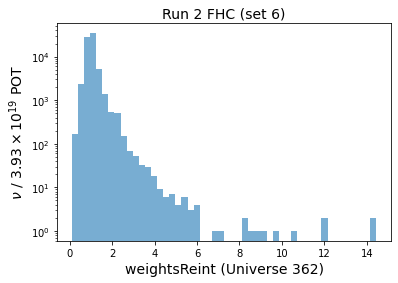

In [25]:
plt.hist(run2_overlay['weightsReint'].str.get(362), 50, alpha=0.6)

plt.xlabel('weightsReint (Universe 362)', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title(title, fontsize=14)

plt.yscale('log')

plt.show()

## Low level overlay comparison with FHC Run 1

In [ ]:
# compare nue vs. numu 
# Run 2 = green 
# Run 1 = red ?

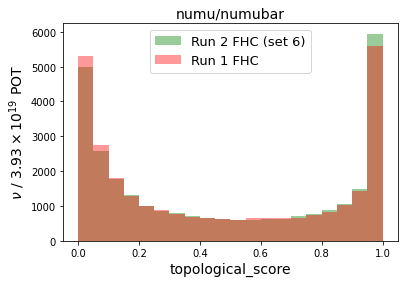

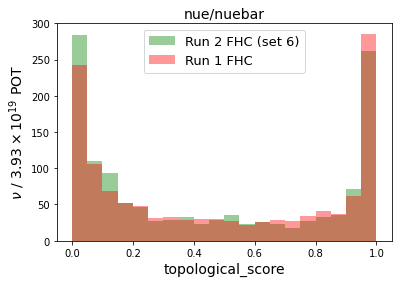

In [30]:
# topological score

plt.hist(run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['topological_score'], 20, range=[0,1], 
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.hist(run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['topological_score'], 20, range=[0,1], 
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.xlabel('topological_score', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('numu/numubar', fontsize=14)

plt.legend(fontsize=13)

plt.show()



plt.hist(run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['topological_score'], 20, range=[0,1], 
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.hist(run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['topological_score'], 20, range=[0,1], 
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.xlabel('topological_score', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('nue/nuebar', fontsize=14)

plt.legend(fontsize=13)

plt.show()

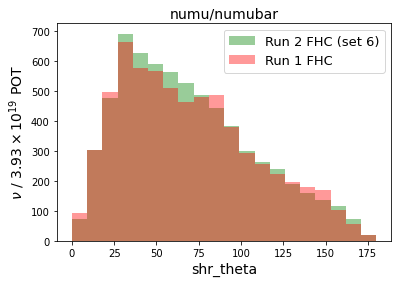

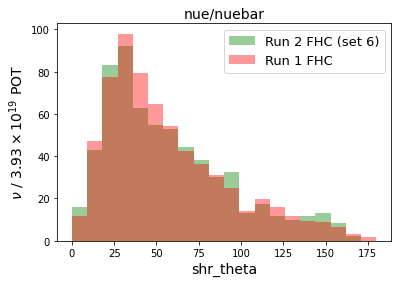

In [31]:
# shower theta 


plt.hist(run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['shr_theta_deg'], 20, range=[0, 180],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['shr_theta_deg'], 20, range=[0, 180],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.xlabel('shr_theta', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('numu/numubar', fontsize=14)

plt.legend(fontsize=13)

plt.show()



plt.hist(run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['shr_theta_deg'], 20, range=[0, 180],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['shr_theta_deg'], 20, range=[0, 180],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.xlabel('shr_theta', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('nue/nuebar', fontsize=14)

plt.legend(fontsize=13)

plt.show()

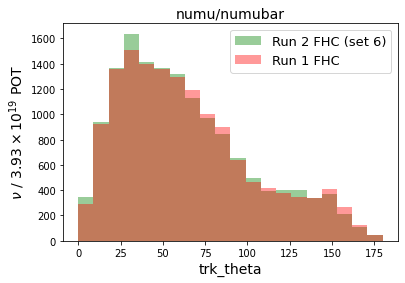

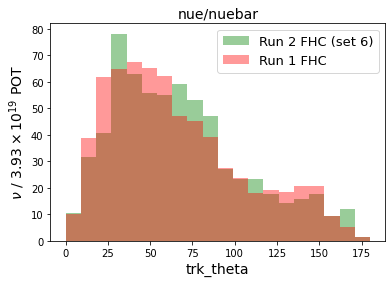

In [37]:
# track theta 

plt.hist(run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['trk_theta_deg'], 20, range=[0, 180],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['trk_theta_deg'], 20, range=[0, 180],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.xlabel('trk_theta', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('numu/numubar', fontsize=14)

plt.legend(fontsize=13)

plt.show()



plt.hist(run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['trk_theta_deg'], 20, range=[0, 180],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['trk_theta_deg'], 20, range=[0, 180],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.xlabel('trk_theta', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('nue/nuebar', fontsize=14)

plt.legend(fontsize=13)

plt.show()


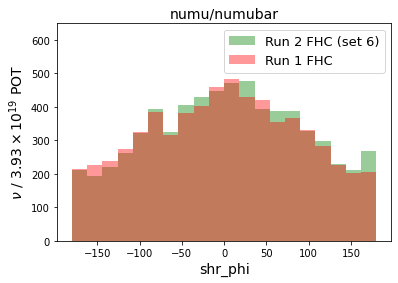

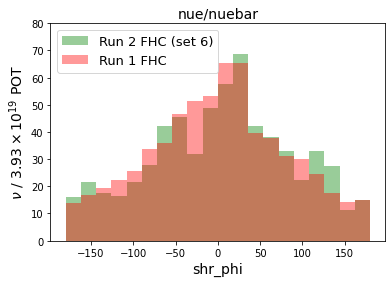

In [68]:
# shower phi 

plt.hist(run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['shr_phi_deg'], 20, range=[-180, 180],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['shr_phi_deg'], 20, range=[-180, 180],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.xlabel('shr_phi', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('numu/numubar', fontsize=14)

plt.legend(fontsize=13)

plt.ylim(0, 650)

plt.show()



plt.hist(run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['shr_phi_deg'], 20, range=[-180, 180],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['shr_phi_deg'], 20, range=[-180, 180],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.xlabel('shr_phi', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('nue/nuebar', fontsize=14)

plt.ylim(0, 80)

plt.legend(fontsize=13)

plt.show()

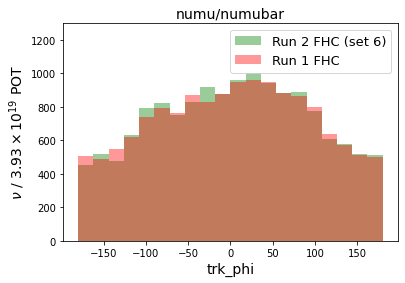

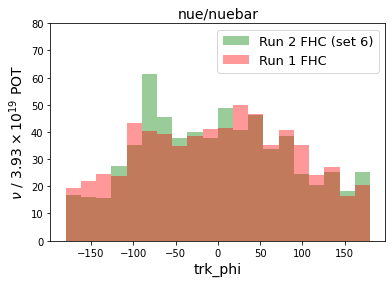

In [71]:
# track phi 

plt.hist(run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['trk_phi_deg'], 20, range=[-180, 180],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['trk_phi_deg'], 20, range=[-180, 180],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.xlabel('trk_phi', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('numu/numubar', fontsize=14)

plt.legend(fontsize=13)
plt.ylim(0, 1300)

plt.show()



plt.hist(run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['trk_phi_deg'], 20, range=[-180, 180],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['trk_phi_deg'], 20, range=[-180, 180],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.xlabel('trk_phi', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('nue/nuebar', fontsize=14)

plt.legend(fontsize=13)
plt.ylim(0, 80)

plt.show()


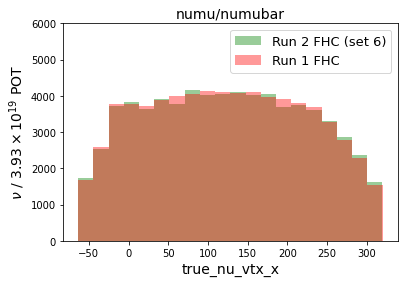

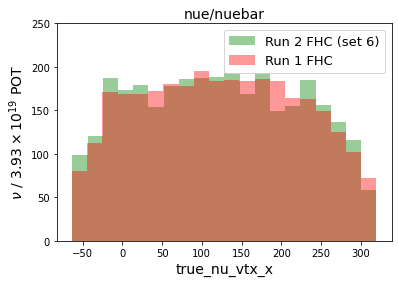

In [73]:
# x pos 

plt.hist(run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['true_nu_vtx_x'], 20,
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['true_nu_vtx_x'], 20,
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.xlabel('true_nu_vtx_x', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('numu/numubar', fontsize=14)

plt.legend(fontsize=13)
plt.ylim(0, 6000)

plt.show()



plt.hist(run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['true_nu_vtx_x'], 20,
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['true_nu_vtx_x'], 20,
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.xlabel('true_nu_vtx_x', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('nue/nuebar', fontsize=14)

plt.legend(fontsize=13)
plt.ylim(0, 250)
plt.show()


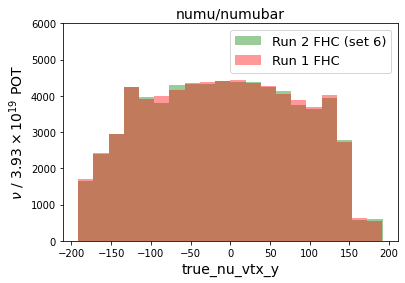

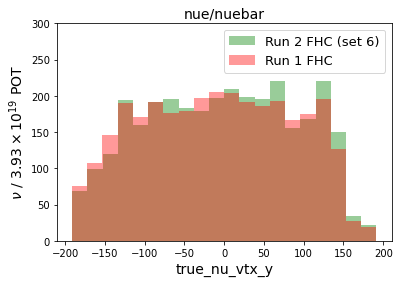

In [75]:
# y pos 

plt.hist(run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['true_nu_vtx_y'], 20,
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['true_nu_vtx_y'], 20,
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.xlabel('true_nu_vtx_y', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('numu/numubar', fontsize=14)

plt.legend(fontsize=13)
plt.ylim(0, 6000)

plt.show()



plt.hist(run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['true_nu_vtx_y'], 20,
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['true_nu_vtx_y'], 20,
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.xlabel('true_nu_vtx_y', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('nue/nuebar', fontsize=14)

plt.legend(fontsize=13)
plt.ylim(0, 300)

plt.show()

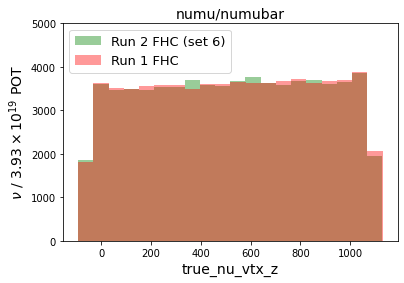

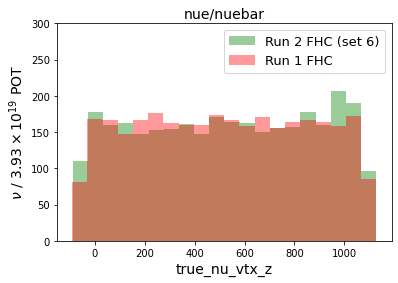

In [77]:
# z pos

plt.hist(run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['true_nu_vtx_z'], 20,
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['true_nu_vtx_z'], 20,
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.xlabel('true_nu_vtx_z', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('numu/numubar', fontsize=14)

plt.legend(fontsize=13)
plt.ylim(0, 5000)

plt.show()



plt.hist(run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['true_nu_vtx_z'], 20,
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['true_nu_vtx_z'], 20,
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.xlabel('true_nu_vtx_z', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('nue/nuebar', fontsize=14)

plt.legend(fontsize=13)
plt.ylim(0, 300)

plt.show()

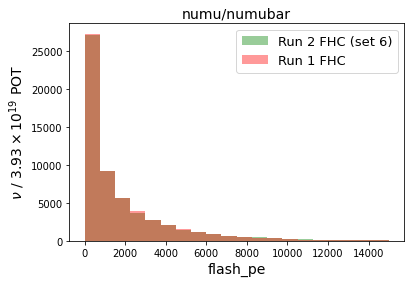

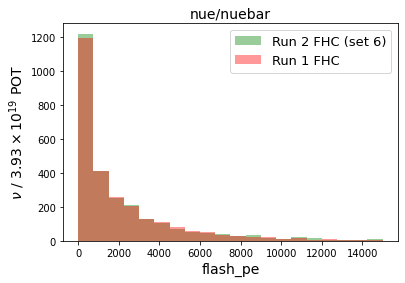

In [62]:
# reco flash pe

plt.hist(run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['flash_pe'], 20, range=[0, 15000],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['flash_pe'], 20, range=[0, 15000],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.xlabel('flash_pe', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('numu/numubar', fontsize=14)

plt.legend(fontsize=13)

plt.show()

plt.hist(run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['flash_pe'], 20, range=[0, 15000],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['flash_pe'], 20, range=[0, 15000],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.xlabel('flash_pe', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('nue/nuebar', fontsize=14)

plt.legend(fontsize=13)

plt.show()

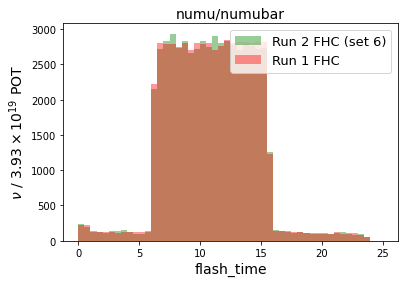

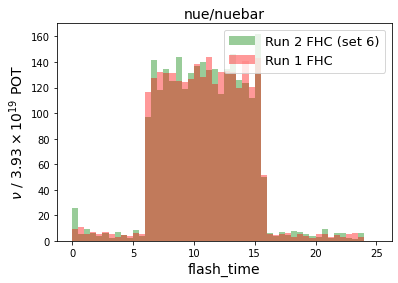

In [64]:
# reco flash time

plt.hist(run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['flash_time'], 50, range=[0, 25],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['flash_time'], 50, range=[0, 25],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==14 or nu_pdg==-14')['totweight_overlay'])

plt.xlabel('flash_time', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('numu/numubar', fontsize=14)

plt.legend(fontsize=13)

plt.show()

plt.hist(run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['flash_time'], 50, range=[0, 25],
         color='green', alpha=0.4, label=title, weights=run2_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])
plt.hist(run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['flash_time'], 50, range=[0, 25],
         color='red', alpha=0.4, label='Run 1 FHC', weights=run1_overlay.query('nu_pdg==12 or nu_pdg==-12')['totweight_overlay'])

plt.xlabel('flash_time', fontsize=14)
plt.ylabel('$\\nu$ / '+pot_string, fontsize=14)

plt.title('nue/nuebar', fontsize=14)

plt.legend(fontsize=13)

plt.show()